In [44]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload
import matplotlib.pyplot as plt
import multiprocessing

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from IPython.display import clear_output, display
import subprocess
import glob
from pathlib import Path
import os
cwd = os.getcwd()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

wavelength = 633e-9
fl = 450e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(1/pxscl_lamD)

zero = np.array([[0,0,0]]).T
v_bias = np.array([[50,50,50]]).T

pxscl_lamD * as_per_lamD

18.389524275269295 arcsec
11.62890385793019


<Quantity 1.58136351 arcsec>

In [137]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [136]:
npsf = 50
cam.set_roi(575, 900, npsf, client0)

In [39]:
cam.set_exptime(0.0001, client0)

INFO:utils:Got semaphore index 1.


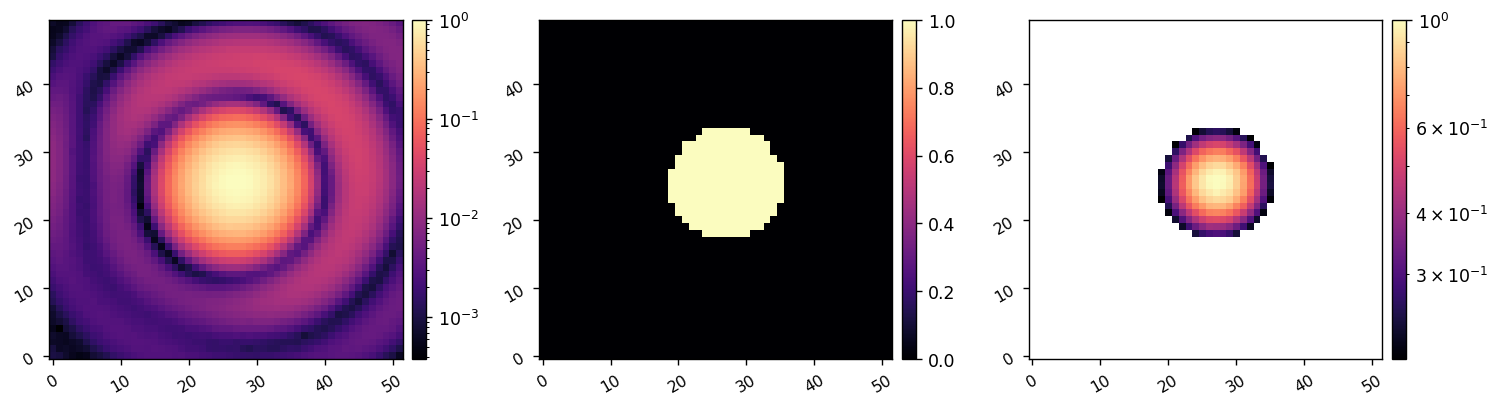

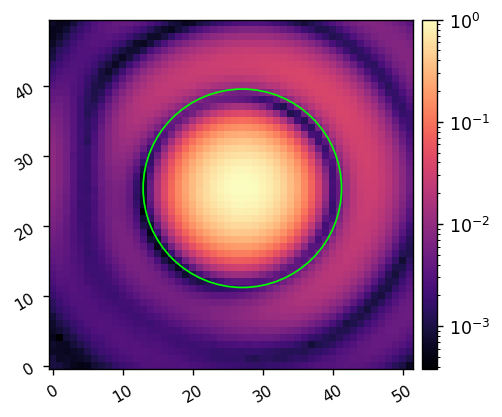

In [138]:
cam.Nframes = 1000
im_bias = cam.snap()

reload(utils)
cen = utils.centroid(im_bias, thresh=0.2, plot=True)
imshow1(im_bias, lognorm=True, patches=[Circle(cen, 1.22/pxscl_lamD, fill=False, color='lime')])


# Setup FSM Interface

In [139]:
fsm_bias_channel = ImageStream('dm00disp00')
fsm_channel = ImageStream('dm00disp10')

In [161]:
fsm_bias_channel.write(v_bias)

In [295]:
fsm_bias_channel.write(zero)

# Setup and record the modulation

In [162]:
import multiprocessing

def modulate_fsm():
    print('Modulating FSM ...')
    i = 0
    while True:
        if i==2: i = 0
        fsm_channel.write(volt_commands[i])
        time.sleep(1/freq - 7.5e-5)
        i += 1

mod = multiprocessing.Process(name='modulation', target=modulate_fsm, )

In [163]:
# Define a step command
amp = 1*u.arcsec

volt_commands = np.zeros((2, 3, 1))
volt_commands[1] = fsm_utils.get_fsm_volts(tip=amp, tilt=0*u.arcsec, dZ=0*u.um)
print(volt_commands)

[[[ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.16794439]
  [-0.08397219]
  [-0.08397219]]]


In [159]:
fsm_channel.write(0*volt_commands[1])

In [285]:
freq = 10000

exp_dir = f'square-mod-{freq:.2f}'
exp_path = Path(f'{cwd}/data/{exp_dir}')

subprocess.run(['mkdir',str(exp_path)])

CompletedProcess(args=['mkdir', '/home/uasal/Projects/fsm-exps/data/square-mod-10000.00'], returncode=0)

In [275]:
reload(fsm_utils)
fsm_utils.delete_all_data(exp_path)

In [286]:
mod = multiprocessing.Process(name='modulation', target=modulate_fsm, )

t_meas = 1
delay = 2

cam.Nframes = 100
frame0 = cam.snap()
utils.save_fits(str(exp_path/'campupil_0.fits'), frame0)

mod.start()
time.sleep(delay)
fsm_utils.toggle_telem_fsm(1, client0, )
fsm_utils.toggle_telem_campupil(1, client0)

time.sleep(t_meas)

fsm_utils.toggle_telem_campupil(0, client0)
fsm_utils.toggle_telem_fsm(0, client0)
mod.terminate()

fsm_channel.write(zero)


Saved data to:  /home/uasal/Projects/fsm-exps/data/square-mod-10000.00/campupil_0.fits
Modulating FSM ...


In [175]:
fsm_utils.toggle_telem_fsm(0, client0)

In [176]:
mod.terminate()
fsm_channel.write(zero)

# Analyze data

In [287]:
# Decompress the .xrif files from the telem_* apps into the desired data directories

telem_cam_path = Path('/opt/MagAOX/telem/campupil/')
telem_fsm_path = Path('/opt/MagAOX/telem/fsm/')

subprocess.run(['xrif2fits','-d',str(telem_cam_path),'-D',exp_path])
clear_output()
subprocess.run(['xrif2fits','-d',str(telem_fsm_path),'-D',exp_path])
clear_output()

getPriorLog empty map
no prior
logger/logMap.cpp 150 getPriorLog empty map
no prior
logger/logMap.cpp 150 getPriorLog empty map
no prior
logger/logMap.cpp 150 getPriorLog empty map
no prior
logger/logMap.cpp 150 getPriorLog empty map
no prior
logger/logMap.cpp 150 getPriorLog empty map
no prior
logger/logMap.cpp 150 getPriorLog empty map
no prior
logger/logMap.cpp 150 getPriorLog empty map
no prior
logger/logMap.cpp 150 getPriorLog empty map
no prior
logger/logMap.cpp 150 getPriorLog empty map
no prior
logger/logMap.cpp 150 getPriorLog empty map
no prior
logger/logMap.cpp 150 getPriorLog empty map
no prior
logger/logMap.cpp 150 getPriorLog empty map
no prior
logger/logMap.cpp 150 getPriorLog empty map
no prior
logger/logMap.cpp 150 getPriorLog empty map
no prior
logger/logMap.cpp 150 getPriorLog empty map
no prior
logger/logMap.cpp 150 getPriorLog empty map
no prior
logger/logMap.cpp 150 getPriorLog empty map
no prior
logger/logMap.cpp 150 getPriorLog empty map
no prior
logger/logMap.c

In [131]:
freq = 100
exp_dir = f'square-mod-{freq:.2f}'
exp_path = Path(f'{cwd}/data/{exp_dir}')


In [288]:

# cam_data_fnames = sorted(glob.glob(str(exp_path/'campupil*20250131*.fits')))
# fsm_data_fnames = sorted(glob.glob(str(exp_path/'dm00disp*20250131*.fits')))
cam_data_fnames = sorted(glob.glob(str(exp_path/'campupil*20250203*.fits')))
fsm_data_fnames = sorted(glob.glob(str(exp_path/'dm00disp*20250203*.fits')))

fsm_data_fnames[0], cam_data_fnames[0]
# fsm_data_fnames

('/home/uasal/Projects/fsm-exps/data/square-mod-10000.00/dm00disp_20250203235628489427444.fits',
 '/home/uasal/Projects/fsm-exps/data/square-mod-10000.00/campupil_20250203235551491145655.fits')

86151.491145655
86188.489427444


Text(0.5, 0, 'frame count')

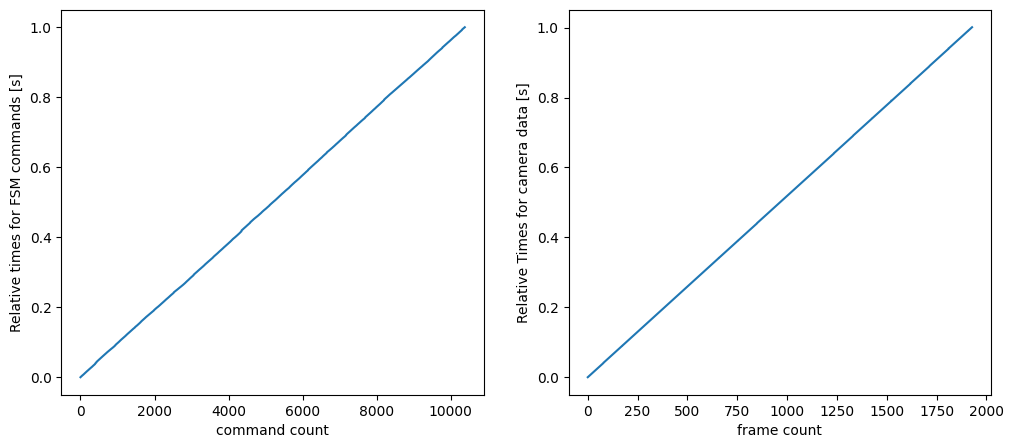

In [289]:
from astropy.io import fits

fsm_commands = []
fsm_times = []
for fname in fsm_data_fnames:
    fsm_commands.append(fits.getdata(fname))
    t_hr = float(fname.split("_")[1][8:10])
    t_min = float(fname.split("_")[1][10:12])
    t_sec = float(fname.split("_")[1][12:-5])/1e9
    fsm_times.append( 3600*t_hr + 60*t_min + t_sec )
fsm_commands = np.array(fsm_commands) 
fsm_times = np.array(fsm_times)
fsm_start = fsm_times[0]
rel_fsm_times = fsm_times - fsm_start

frames = []
cam_times = []
for fname in cam_data_fnames:
    frames.append(fits.getdata(fname))
    t_hr = float(fname.split("_")[1][8:10])
    t_min = float(fname.split("_")[1][10:12])
    t_sec = float(fname.split("_")[1][12:-5])/1e9
    cam_times.append( 3600*t_hr + 60*t_min + t_sec )
frames = np.array(frames) 
cam_times = np.array(cam_times)
cam_start = cam_times[0]
print(cam_start)
rel_cam_times = cam_times - fsm_start
rel_cam_times -= rel_cam_times.min()

print(fsm_start)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(rel_fsm_times)
plt.ylabel('Relative times for FSM commands [s]')
plt.xlabel('command count')

plt.subplot(122)
plt.plot(rel_cam_times)
plt.ylabel('Relative Times for camera data [s]')
plt.xlabel('frame count')

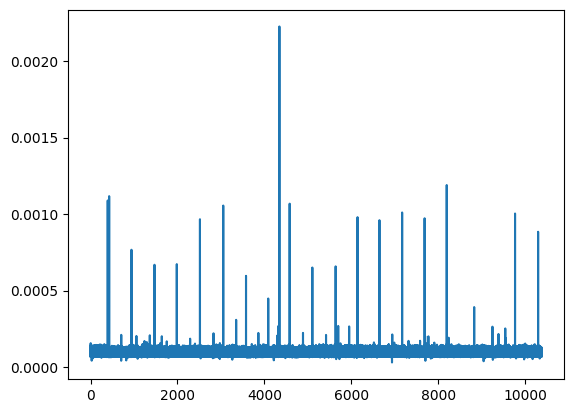

In [290]:
fsm_time_steps = (rel_fsm_times[1:] - rel_fsm_times[:-1])[:-1]
plt.plot(fsm_time_steps)

In [292]:
1/freq, np.mean(fsm_time_steps), 1/np.mean(fsm_time_steps), fsm_commands.shape

(0.0001,
 np.float64(9.641558095544558e-05),
 np.float64(10371.767613598762),
 (10378, 3, 1))

In [254]:
print(fsm_start) 
print(cam_start)
print(fsm_start - cam_start)

85634.123656666
85597.166360921
36.95729574500001


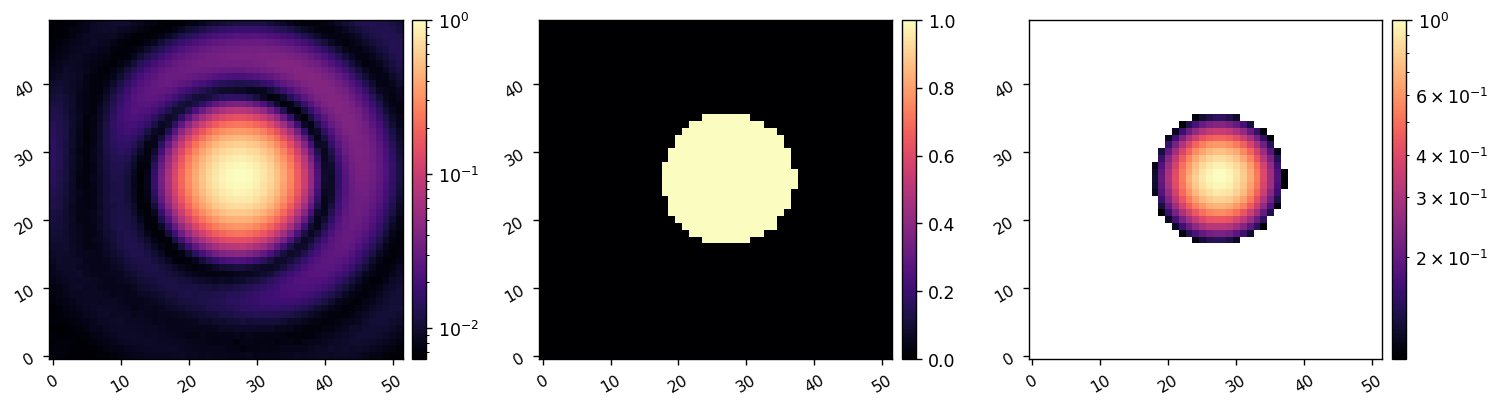

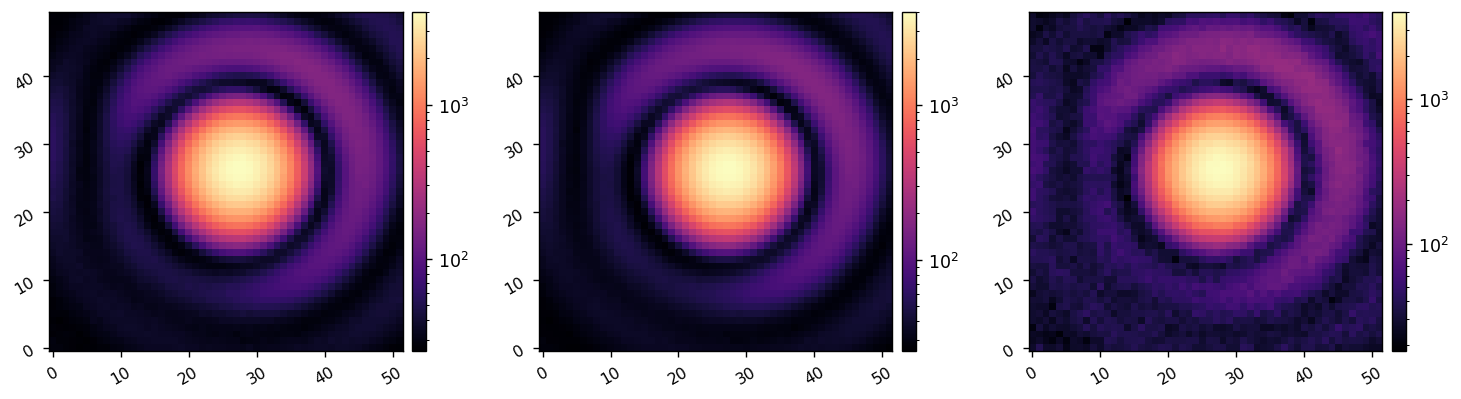

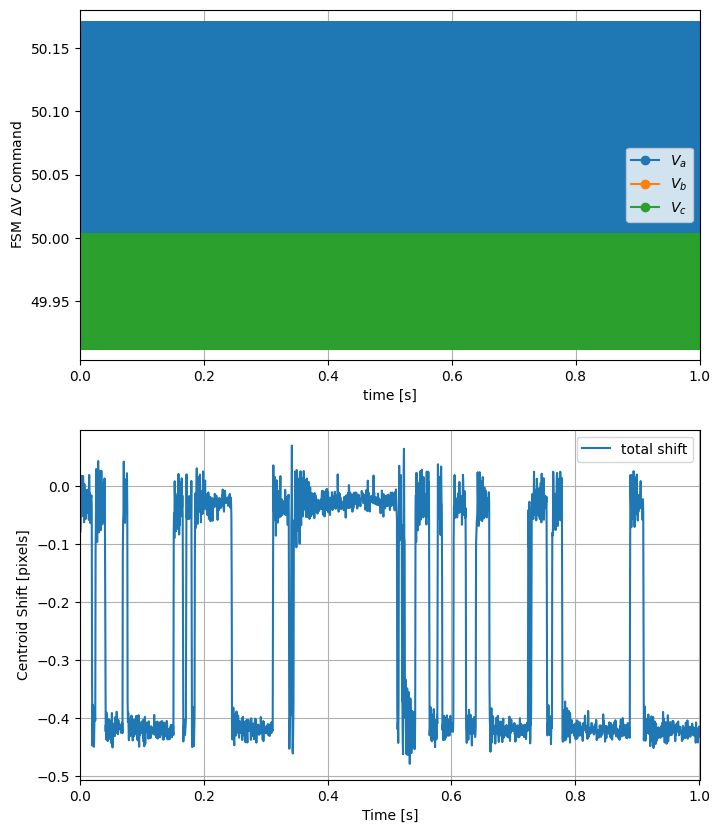

In [294]:
cthresh = 0.1

N = len(cam_data_fnames)
frame0 = utils.load_fits(str(exp_path/'campupil_0.fits'))
cen_0 = utils.centroid(frame0.astype(float), thresh=cthresh, plot=True)
mean_frame = np.mean(frames, axis=0)
imshow3(frame0, mean_frame, frames[0], lognorm=True)

shift_pix = []
total_shift_pix = []
for i in range(N):
    cen = utils.centroid(frames[i].astype(float), thresh=cthresh, plot=0)
    shift = cen - cen_0
    shift_pix.append(shift)
    if shift[0]>0 and shift[1]>0:
        total_shift_pix.append(np.sqrt(shift[0]**2 + shift[1]**2))
    elif shift[0]>0 and shift[1]<0:
        total_shift_pix.append(np.sqrt(shift[0]**2 + shift[1]**2))
    elif shift[0]<0 and shift[1]>0:
        total_shift_pix.append(-np.sqrt(shift[0]**2 + shift[1]**2))
    elif shift[0]<0 and shift[1]<0:
        total_shift_pix.append(-np.sqrt(shift[0]**2 + shift[1]**2))
shift_pix = np.array(shift_pix)
total_shift_pix = np.array(total_shift_pix)

shift_as = shift_pix * pxscl_lamD * as_per_lamD # pixels * (lamD/pixel) * (as/lamD)
total_shift_as = total_shift_pix * pxscl_lamD * as_per_lamD

total_shift = np.sqrt( np.sum( np.square(shift_pix), axis=1) )

shift_as = shift_pix * pxscl_lamD * as_per_lamD # pixels * (lamD/pixel) * (as/lamD)
shift_as = np.sqrt( np.sum( np.square(shift_as), axis=1) )

fig = plt.figure(figsize=(8,10))
plt.subplot(211)
plt.plot(rel_fsm_times, fsm_commands[:,0], '-o', label='$V_a$')
plt.plot(rel_fsm_times, fsm_commands[:,1], '-o', label='$V_b$')
plt.plot(rel_fsm_times, fsm_commands[:,2], '-o', label='$V_c$')
plt.ylabel('FSM $\Delta$V Command')
plt.xlabel('time [s]')
plt.xlim([0,rel_fsm_times.max()])
# plt.xlim([0, 1])
plt.grid()
plt.legend()

plt.subplot(212)
# plt.plot(rel_cam_times, shift_pix[:,0], label='x-coordinate')
# plt.plot(rel_cam_times, shift_pix[:,1], label='y-coordinate')
plt.plot(rel_cam_times, total_shift_pix, label='total shift')
# plt.plot(rel_cam_times, shift_as[:,0], label='x-coordinate')
# plt.plot(rel_cam_times, shift_as[:,1], label='y-coordinate')
# plt.plot(rel_cam_times, total_shift_as, label='total shift')
plt.ylabel('Centroid Shift [pixels]')
plt.xlabel('Time [s]')
plt.xlim([0, rel_cam_times.max()])
# plt.xlim([0, 1])
plt.grid()
plt.legend()

plt.show()

In [257]:
fsm_commands.shape

(502, 3, 1)

79.0


(0.0, 0.9587216660002014)

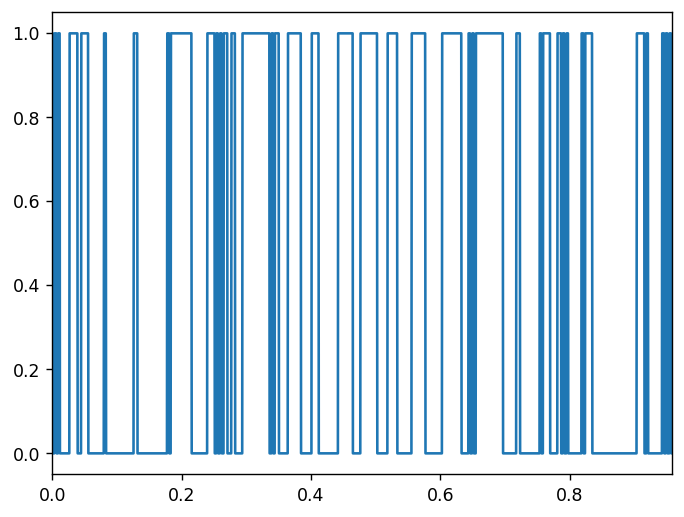

In [258]:
# shift_thresh = shift_as.max()/2
# shift_ud = shift_as>shift_thresh

shift_thresh = total_shift_pix.max()/2
# shift_thresh = 0.15
shift_ud = total_shift_pix>shift_thresh

tmax = rel_cam_times[-1] - rel_cam_times[0]

steps = np.abs(shift_ud[1:].astype(float) - shift_ud[:-1].astype(float))
step_count = np.sum(steps)
print(step_count)

plt.figure(dpi=125)
plt.plot(rel_cam_times, shift_ud,)
# plt.xlabel('time [s]')
plt.xlim([0,rel_cam_times.max()])
# plt.xlim([0, 1])

# plt.plot(rel_cam_times[1:], steps,)
# plt.xlabel('time [s]')
# plt.xlim([0,tmax])
# plt.xlim([0, 1])


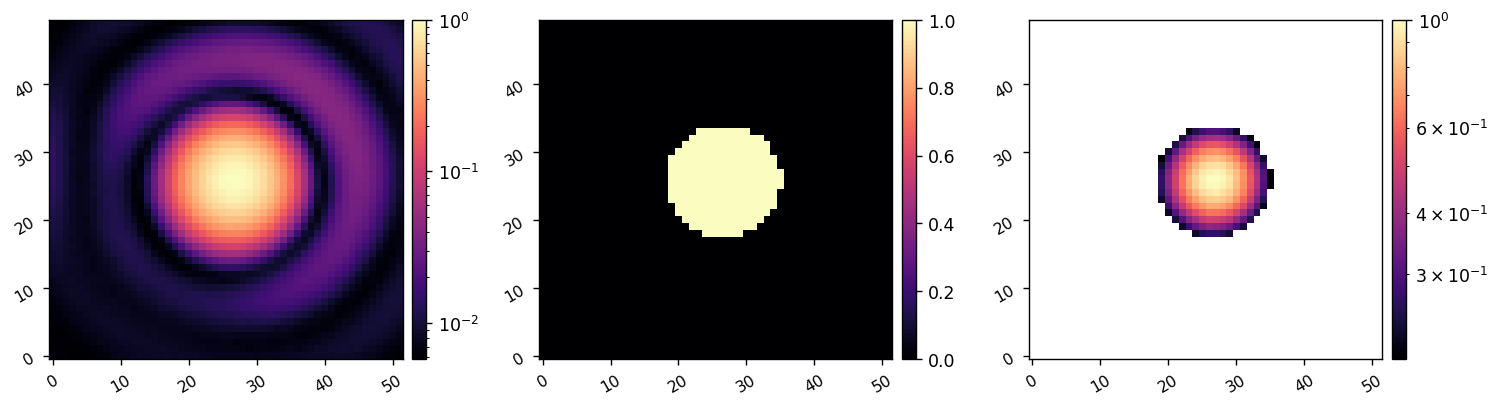

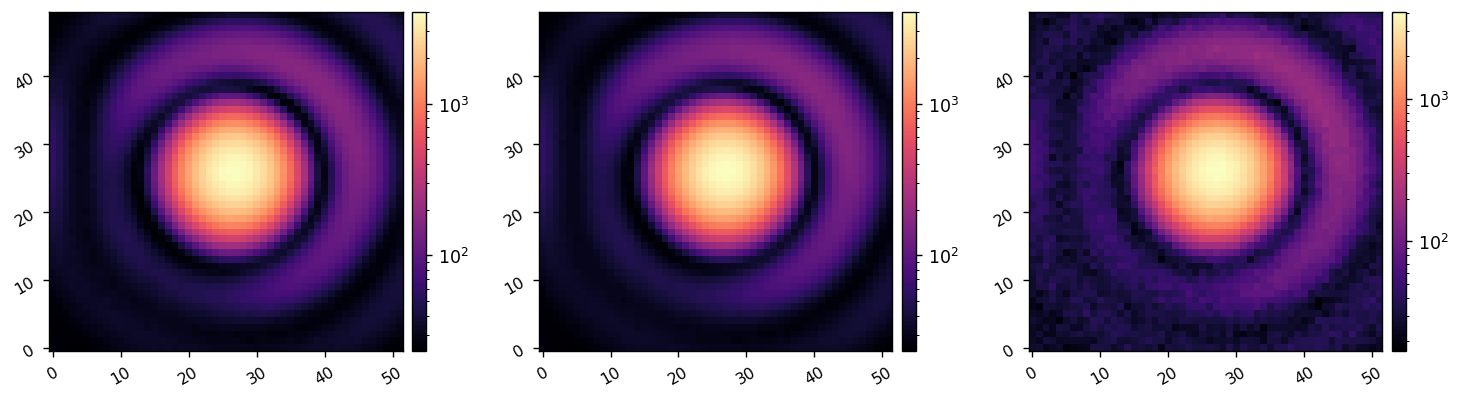

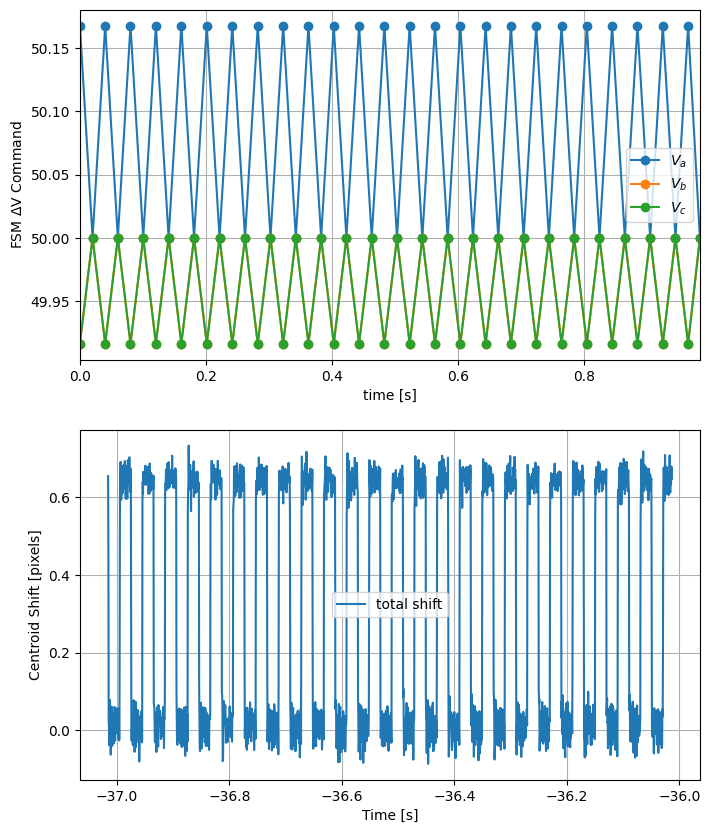

In [96]:
cthresh = 0.2

N = len(cam_data_fnames)
frame0 = utils.load_fits(str(exp_path/'campupil_0.fits'))
cen_0 = utils.centroid(frame0.astype(float), thresh=cthresh, plot=True)
mean_frame = np.mean(frames, axis=0)
imshow3(frame0, mean_frame, frames[0], lognorm=True)

shift_pix = []
total_shift_pix = []
for i in range(N):
    cen = utils.centroid(frames[i].astype(float), thresh=cthresh, plot=0)
    shift = cen - cen_0
    shift_pix.append(shift)
    if shift[0]>0 and shift[1]>0:
        total_shift_pix.append(np.sqrt(shift[0]**2 + shift[1]**2))
    elif shift[0]>0 and shift[1]<0:
        total_shift_pix.append(np.sqrt(shift[0]**2 + shift[1]**2))
    elif shift[0]<0 and shift[1]>0:
        total_shift_pix.append(-np.sqrt(shift[0]**2 + shift[1]**2))
    elif shift[0]<0 and shift[1]<0:
        total_shift_pix.append(-np.sqrt(shift[0]**2 + shift[1]**2))
shift_pix = np.array(shift_pix)
total_shift_pix = np.array(total_shift_pix)

shift_as = shift_pix * pxscl_lamD * as_per_lamD # pixels * (lamD/pixel) * (as/lamD)
total_shift_as = total_shift_pix * pxscl_lamD * as_per_lamD

total_shift = np.sqrt( np.sum( np.square(shift_pix), axis=1) )

shift_as = shift_pix * pxscl_lamD * as_per_lamD # pixels * (lamD/pixel) * (as/lamD)
shift_as = np.sqrt( np.sum( np.square(shift_as), axis=1) )

fig = plt.figure(figsize=(8,10))
plt.subplot(211)
plt.plot(rel_fsm_times, fsm_commands[:,0], '-o', label='$V_a$')
plt.plot(rel_fsm_times, fsm_commands[:,1], '-o', label='$V_b$')
plt.plot(rel_fsm_times, fsm_commands[:,2], '-o', label='$V_c$')
plt.ylabel('FSM $\Delta$V Command')
plt.xlabel('time [s]')
plt.xlim([0,rel_fsm_times.max()])
# plt.xlim([0, 1])
plt.grid()
plt.legend()

plt.subplot(212)
# plt.plot(rel_cam_times, shift_pix[:,0], label='x-coordinate')
# plt.plot(rel_cam_times, shift_pix[:,1], label='y-coordinate')
# plt.plot(rel_cam_times, total_shift_pix, label='total shift')
# plt.plot(rel_cam_times, shift_as[:,0], label='x-coordinate')
# plt.plot(rel_cam_times, shift_as[:,1], label='y-coordinate')
plt.plot(rel_cam_times, total_shift_as, label='total shift')
plt.ylabel('Centroid Shift [pixels]')
plt.xlabel('Time [s]')
# plt.xlim([0, rel_cam_times.max()])
# plt.xlim([0, 1])
plt.grid()
plt.legend()

plt.show()

50.0


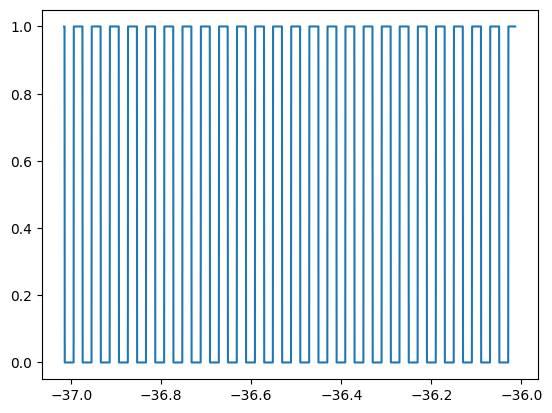

In [97]:
shift_thresh = shift_as.max()/2.2
# shift_thresh = 0.1*u.arcsec

tmax = rel_cam_times[-1] - rel_cam_times[0]

shift_ud = shift_as>shift_thresh
steps = np.abs(shift_ud[1:].astype(float) - shift_ud[:-1].astype(float))
step_count = np.sum(steps)
print(step_count)

plt.plot(rel_cam_times, shift_ud,)
# plt.xlabel('time [s]')
# plt.xlim([0,times.max()])
# plt.xlim([0, 1])

# plt.plot(rel_cam_times[1:], steps,)
# plt.xlabel('time [s]')
# plt.xlim([0,tmax])
# plt.xlim([0, 1])
